# Advanced Deep Learning Models for Airbnb Price Prediction

This notebook focuses on advanced deep learning architectures specifically designed for tabular data:
- TabNet (Google's tabular deep learning model)
- Neural Oblivious Decision Trees (NODE)
- Wide & Deep Networks
- Attention-based Neural Networks
- Autoencoder-based feature learning
- Custom ensemble deep learning models

## 1. Import Advanced Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Dense, Dropout, BatchNormalization, Input, Concatenate,
    Embedding, Flatten, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Reshape, Lambda
)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2

# TabNet
try:
    from pytorch_tabnet.tab_model import TabNetRegressor
    import torch
    tabnet_available = True
except ImportError:
    print("TabNet not installed. Installing...")
    import subprocess
    try:
        subprocess.check_call(["pip", "install", "pytorch-tabnet", "torch"])
        from pytorch_tabnet.tab_model import TabNetRegressor
        import torch
        tabnet_available = True
    except:
        print("Could not install TabNet. Skipping TabNet models.")
        tabnet_available = False

# Standard ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model persistence
import joblib
import json
import os
from datetime import datetime

print(f"TensorFlow version: {tf.__version__}")
print(f"TabNet available: {tabnet_available}")
print("Advanced deep learning libraries imported successfully!")

TabNet not installed. Installing...
TensorFlow version: 2.18.0
TabNet available: True
Advanced deep learning libraries imported successfully!
TensorFlow version: 2.18.0
TabNet available: True
Advanced deep learning libraries imported successfully!


## 2. Load and Prepare Data

In [2]:
# Load data
BASE_DIR = r"c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard"
DATA_PATH = os.path.join(BASE_DIR, "dataset", "airbnb_bali_ml_ready.csv")
MODEL_BASE_PATH = os.path.join(BASE_DIR, "ml_models")

df = pd.read_csv(DATA_PATH)

# Prepare features
exclude_cols = ['room_id', 'check_in_date', 'check_out_date', 'full_url', 'data_extraction_date', 'analysis_version']
feature_cols = [col for col in df.columns if col not in exclude_cols and col != 'price']
target_col = 'price'

X = df[feature_cols].copy()
y = df[target_col].copy()

# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Dataset shape: {X.shape}")
print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")
print(f"Target statistics: mean={y.mean():.2f}, std={y.std():.2f}")

Dataset shape: (833, 9)
Categorical features: ['season', 'locale', 'currency']
Numerical features: ['stay_duration', 'check_in_month', 'check_in_day_of_week', 'is_weekend', 'check_in_year', 'check_in_week_of_year']
Target statistics: mean=81.93, std=35.15


In [3]:
# Advanced preprocessing for deep learning
X_processed = X.copy()
label_encoders = {}
embedding_dims = {}

# Encode categorical variables and determine embedding dimensions
for col in categorical_features:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
    
    # Calculate embedding dimension (rule of thumb: min(50, (cardinality + 1) // 2))
    cardinality = len(le.classes_)
    embed_dim = min(50, (cardinality + 1) // 2)
    embedding_dims[col] = {'cardinality': cardinality, 'embedding_dim': embed_dim}
    
    print(f"{col}: {cardinality} categories, embedding dim: {embed_dim}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Scale numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numerical_features])
X_val_num = scaler.transform(X_val[numerical_features])
X_test_num = scaler.transform(X_test[numerical_features])

# Scale target for better training
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

print(f"\nData split completed:")
print(f"Training: {X_train.shape}")
print(f"Validation: {X_val.shape}")
print(f"Test: {X_test.shape}")

season: 4 categories, embedding dim: 2
locale: 1 categories, embedding dim: 1
currency: 1 categories, embedding dim: 1

Data split completed:
Training: (532, 9)
Validation: (134, 9)
Test: (167, 9)


## 3. Wide & Deep Network

In [4]:
def create_wide_deep_model(numerical_features, categorical_features, embedding_dims):
    """Create Wide & Deep model architecture"""
    
    # Inputs
    numerical_input = Input(shape=(len(numerical_features),), name='numerical_input')
    categorical_inputs = {}
    
    for col in categorical_features:
        categorical_inputs[col] = Input(shape=(), name=f'{col}_input', dtype='int32')
    
    # Wide part (linear model)
    wide_part = Dense(1, activation='linear', name='wide_part')(numerical_input)
    
    # Deep part (neural network with embeddings)
    embeddings = []
    
    # Add numerical features to deep part
    embeddings.append(numerical_input)
    
    # Add categorical embeddings
    for col in categorical_features:
        vocab_size = embedding_dims[col]['cardinality']
        embed_dim = embedding_dims[col]['embedding_dim']
        
        embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            name=f'{col}_embedding'
        )(categorical_inputs[col])
        
        embedding = Flatten()(embedding)
        embeddings.append(embedding)
    
    # Concatenate all embeddings
    deep_input = Concatenate(name='deep_concatenate')(embeddings)
    
    # Deep network
    deep = Dense(512, activation='relu')(deep_input)
    deep = BatchNormalization()(deep)
    deep = Dropout(0.3)(deep)
    
    deep = Dense(256, activation='relu')(deep)
    deep = BatchNormalization()(deep)
    deep = Dropout(0.3)(deep)
    
    deep = Dense(128, activation='relu')(deep)
    deep = Dropout(0.2)(deep)
    
    deep = Dense(64, activation='relu')(deep)
    deep_part = Dense(1, activation='linear', name='deep_part')(deep)
    
    # Combine wide and deep
    output = tf.keras.layers.Add(name='wide_deep_output')([wide_part, deep_part])
    
    # Create model
    inputs = [numerical_input] + list(categorical_inputs.values())
    model = Model(inputs=inputs, outputs=output, name='wide_deep_model')
    
    return model

print("\nCreating Wide & Deep Model...")
wide_deep_model = create_wide_deep_model(numerical_features, categorical_features, embedding_dims)
wide_deep_model.summary()

# Compile model
wide_deep_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Prepare input data for Wide & Deep model
def prepare_wide_deep_input(X_num, X_cat):
    inputs = [X_num]
    for col in categorical_features:
        inputs.append(X_cat[col].values)
    return inputs

train_inputs = prepare_wide_deep_input(X_train_num, X_train[categorical_features])
val_inputs = prepare_wide_deep_input(X_val_num, X_val[categorical_features])
test_inputs = prepare_wide_deep_input(X_test_num, X_test[categorical_features])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)
]

# Train Wide & Deep model
print("Training Wide & Deep model...")
history_wd = wide_deep_model.fit(
    train_inputs, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(val_inputs, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

# Evaluate Wide & Deep model
y_pred_wd_scaled = wide_deep_model.predict(test_inputs, verbose=0)
y_pred_wd = target_scaler.inverse_transform(y_pred_wd_scaled).flatten()

wd_r2 = r2_score(y_test, y_pred_wd)
wd_rmse = np.sqrt(mean_squared_error(y_test, y_pred_wd))
wd_mae = mean_absolute_error(y_test, y_pred_wd)

print(f"\nWide & Deep Model Performance:")
print(f"R² Score: {wd_r2:.4f}")
print(f"RMSE: {wd_rmse:.2f}")
print(f"MAE: {wd_mae:.2f}")

# Save model
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
wd_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"wide_deep_model_{timestamp}.h5")
wide_deep_model.save(wd_path)
print(f"Wide & Deep model saved: {wd_path}")


Creating Wide & Deep Model...


Model: "wide_deep_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ season_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locale_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_input      │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_embedding    │ (None, 2)         │          8 │ season_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locale_embedding    │ (None, 1)         │          1 │ locale_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_embedding  │ (None, 1)         │          1 │ currency_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2)         │          0 │ season_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 1)         │          0 │ locale_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 1)         │          0 │ currency_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ deep_concatenate    │ (None, 10)        │          0 │ numerical_input[… │
│ (Concatenate)       │                   │            │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0],  │
│                     │                   │            │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │      5,632 │ deep_concatenate… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     32,896 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]   

 Total params: 181,266 (708.07 KB)

 Trainable params: 179,730 (702.07 KB)

 Non-trainable params: 1,536 (6.00 KB)

Training Wide & Deep model...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.4762 - mae: 1.1308 - val_loss: 1.3055 - val_mae: 0.8275 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 2.4762 - mae: 1.1308 - val_loss: 1.3055 - val_mae: 0.8275 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5893 - mae: 0.9496 - val_loss: 1.4800 - val_mae: 0.8418 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5893 - mae: 0.9496 - val_loss: 1.4800 - val_mae: 0.8418 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3399 - mae: 0.8826 - val_loss: 1.4315 - val_mae: 0.8408 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3399 - mae: 0.8826 - val_loss: 1.4315 - val_mae: 0.8408 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3365 - mae: 0.8679 - val_loss: 1.4283 - val_mae: 0.8410 - lea


Wide & Deep Model Performance:
R² Score: -0.3657
RMSE: 36.18
MAE: 27.45
Wide & Deep model saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\wide_deep_model_20251113_145005.h5


## 4. Attention-based Neural Network

In [6]:
def create_attention_model(numerical_features, categorical_features, embedding_dims):
    """Create Attention-based neural network"""
    
    # Inputs
    numerical_input = Input(shape=(len(numerical_features),), name='numerical_input')
    categorical_inputs = {}
    
    for col in categorical_features:
        categorical_inputs[col] = Input(shape=(), name=f'{col}_input', dtype='int32')
    
    # Process numerical features
    num_dense = Dense(128, activation='relu')(numerical_input)
    num_dense = BatchNormalization()(num_dense)
    num_reshaped = Reshape((1, 128))(num_dense)  # Add sequence dimension for attention
    
    # Process categorical features with embeddings
    categorical_embeddings = []

    for col in categorical_features:
        vocab_size = embedding_dims[col]['cardinality']
        embed_dim = min(64, embedding_dims[col]['embedding_dim'] * 2)

        embedding = Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            name=f'{col}_embedding'
        )(categorical_inputs[col])
        
        # Project embedding to same dim as numerical features
        embedding_projected = Dense(128, activation='relu')(embedding)
        embedding_reshaped = Reshape((1, 128))(embedding_projected)
        
        categorical_embeddings.append(embedding_reshaped)
    
    # Combine all features
    all_features = [num_reshaped] + categorical_embeddings
    combined_features = Concatenate(axis=1)(all_features)
    
    # Multi-head attention
    attention_output = MultiHeadAttention(
        num_heads=8,
        key_dim=64,
        dropout=0.1
    )(combined_features, combined_features)
    
    # Add residual connection
    attention_output = tf.keras.layers.Add()([combined_features, attention_output])
    attention_output = LayerNormalization()(attention_output)
    
    # Global pooling
    pooled = GlobalAveragePooling1D()(attention_output)
    
    # Final dense layers
    dense = Dense(256, activation='relu')(pooled)
    dense = Dropout(0.3)(dense)
    dense = Dense(128, activation='relu')(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation='relu')(dense)
    
    output = Dense(1, activation='linear')(dense)
    
    # Create model
    inputs = [numerical_input] + list(categorical_inputs.values())
    model = Model(inputs=inputs, outputs=output, name='attention_model')
    
    return model

print("\nCreating Attention-based Model...")
attention_model = create_attention_model(numerical_features, categorical_features, embedding_dims)
attention_model.summary()

# Compile model
attention_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=1e-4),
    loss='mse',
    metrics=['mae']
)

# Train Attention model
print("Training Attention model...")
history_att = attention_model.fit(
    train_inputs, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(val_inputs, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

# Evaluate Attention model
y_pred_att_scaled = attention_model.predict(test_inputs, verbose=0)
y_pred_att = target_scaler.inverse_transform(y_pred_att_scaled).flatten()

att_r2 = r2_score(y_test, y_pred_att)
att_rmse = np.sqrt(mean_squared_error(y_test, y_pred_att))
att_mae = mean_absolute_error(y_test, y_pred_att)

print(f"\nAttention Model Performance:")
print(f"R² Score: {att_r2:.4f}")
print(f"RMSE: {att_rmse:.2f}")
print(f"MAE: {att_mae:.2f}")

# Save model
att_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"attention_model_{timestamp}.h5")
attention_model.save(att_path)
print(f"Attention model saved: {att_path}")


Creating Attention-based Model...


Model: "attention_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ numerical_input     │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locale_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_input      │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │        896 │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ season_embedding    │ (None, 4)         │         16 │ season_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ locale_embedding    │ (None, 2)         │          2 │ locale_input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ currency_embedding  │ (None, 2)         │          2 │ currency_input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │        640 │ season_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │        384 │ locale_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │        384 │ currency_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 1, 128)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, 1, 128)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 128)    │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_7 (Reshape) │ (None, 1, 128)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 4, 128)    │          0 │ reshape_4[0][0],  │
│ (Concatenate)       │                   │            │ reshape_5[0][0],  │
│                     │                   │            │ reshape_6[0][0],  │
│                     │                   │            │ reshape_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 4, 128)    │    263,808 │ concatenate_1[0]… │
│ (MultiHeadAttentio… │                   │            │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 4, 128)    │          0 │ concatenate_1[0]

 Total params: 341,141 (1.30 MB)

 Trainable params: 340,885 (1.30 MB)

 Non-trainable params: 256 (1.00 KB)

Training Attention model...
Epoch 1/100
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.0560 - mae: 0.8011 - val_loss: 0.8133 - val_mae: 0.7094 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 1.0560 - mae: 0.8011 - val_loss: 0.8133 - val_mae: 0.7094 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8643 - mae: 0.7267 - val_loss: 0.8070 - val_mae: 0.6963 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8643 - mae: 0.7267 - val_loss: 0.8070 - val_mae: 0.6963 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9158 - mae: 0.7461 - val_loss: 0.8366 - val_mae: 0.7163 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.9158 - mae: 0.7461 - val_loss: 0.8366 - val_mae: 0.7163 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9111 - mae: 0.7360 - val_loss: 0.8109 - val_ma


Attention Model Performance:
R² Score: 0.0255
RMSE: 30.57
MAE: 24.43
Attention model saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\attention_model_20251113_145005.h5


## 5. TabNet Model (if available)

In [9]:
if tabnet_available:
    print("\nTraining TabNet Model...")
    
    # Prepare data for TabNet (needs numpy arrays)
    X_train_tabnet = X_train.values.astype(np.float32)
    X_val_tabnet = X_val.values.astype(np.float32)
    X_test_tabnet = X_test.values.astype(np.float32)
    
    y_train_tabnet = y_train.values.reshape(-1, 1).astype(np.float32)
    y_val_tabnet = y_val.values.reshape(-1, 1).astype(np.float32)
    
    # Create TabNet model
    tabnet_model = TabNetRegressor(
        n_d=64,
        n_a=64,
        n_steps=5,
        gamma=1.5,
        lambda_sparse=1e-3,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
        scheduler_fn=None,
        mask_type='entmax',
        verbose=1,
        seed=42
    )
    
    # Train TabNet
    tabnet_model.fit(
        X_train_tabnet, y_train_tabnet,
        eval_set=[(X_val_tabnet, y_val_tabnet)],
        max_epochs=100,
        patience=20,
        batch_size=256,
        virtual_batch_size=128,
        num_workers=0,
        drop_last=False
    )
    
    # Evaluate TabNet
    y_pred_tabnet = tabnet_model.predict(X_test_tabnet).flatten()
    
    tabnet_r2 = r2_score(y_test, y_pred_tabnet)
    tabnet_rmse = np.sqrt(mean_squared_error(y_test, y_pred_tabnet))
    tabnet_mae = mean_absolute_error(y_test, y_pred_tabnet)
    
    print(f"\nTabNet Model Performance:")
    print(f"R² Score: {tabnet_r2:.4f}")
    print(f"RMSE: {tabnet_rmse:.2f}")
    print(f"MAE: {tabnet_mae:.2f}")
    
    # Save TabNet model
    tabnet_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"tabnet_model_{timestamp}")
    os.makedirs(tabnet_path, exist_ok=True)
    tabnet_model.save_model(tabnet_path)
    print(f"TabNet model saved: {tabnet_path}")
    
    # Feature importance from TabNet
    feature_importance_tabnet = pd.DataFrame({
        'feature': feature_cols,
        'importance': tabnet_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nTabNet Feature Importance (Top 10):")
    print(feature_importance_tabnet.head(10))
    
else:
    print("\nTabNet not available. Skipping TabNet training.")
    tabnet_r2 = tabnet_rmse = tabnet_mae = None


Training TabNet Model...
epoch 0  | loss: 7840.43344| val_0_mse: 52382.9375|  0:00:00s
epoch 1  | loss: 5991.80525| val_0_mse: 752993.8125|  0:00:00s
epoch 0  | loss: 7840.43344| val_0_mse: 52382.9375|  0:00:00s
epoch 1  | loss: 5991.80525| val_0_mse: 752993.8125|  0:00:00s
epoch 2  | loss: 4410.8889| val_0_mse: 4981668.5|  0:00:00s
epoch 3  | loss: 3130.8888| val_0_mse: 450102.5|  0:00:00s
epoch 2  | loss: 4410.8889| val_0_mse: 4981668.5|  0:00:00s
epoch 3  | loss: 3130.8888| val_0_mse: 450102.5|  0:00:00s
epoch 4  | loss: 2144.69104| val_0_mse: 7540970.0|  0:00:00s
epoch 5  | loss: 1387.96107| val_0_mse: 6899790.5|  0:00:01s
epoch 4  | loss: 2144.69104| val_0_mse: 7540970.0|  0:00:00s
epoch 5  | loss: 1387.96107| val_0_mse: 6899790.5|  0:00:01s
epoch 6  | loss: 1087.14612| val_0_mse: 668564288.0|  0:00:01s
epoch 7  | loss: 1284.46022| val_0_mse: 350612768.0|  0:00:01s
epoch 6  | loss: 1087.14612| val_0_mse: 668564288.0|  0:00:01s
epoch 7  | loss: 1284.46022| val_0_mse: 350612768.0| 

## 6. Autoencoder-based Feature Learning

In [10]:
def create_autoencoder_model(input_dim, encoding_dim=128):
    """Create autoencoder for feature learning"""
    
    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(256, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dropout(0.2)(encoded)
    
    encoded = Dense(encoding_dim, activation='relu', name='encoded_features')(encoded)
    
    # Decoder
    decoded = Dense(256, activation='relu')(encoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(512, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dropout(0.2)(decoded)
    
    decoded = Dense(input_dim, activation='linear')(decoded)
    
    # Autoencoder model
    autoencoder = Model(input_layer, decoded, name='autoencoder')
    
    # Encoder model (for feature extraction)
    encoder = Model(input_layer, encoded, name='encoder')
    
    return autoencoder, encoder

print("\nCreating Autoencoder for feature learning...")

# Prepare full dataset for autoencoder training (unsupervised)
X_full_scaled = scaler.fit_transform(X_processed)

# Create autoencoder
autoencoder, encoder = create_autoencoder_model(X_full_scaled.shape[1], encoding_dim=64)
autoencoder.summary()

# Compile autoencoder
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

# Train autoencoder
print("Training Autoencoder...")
ae_history = autoencoder.fit(
    X_full_scaled, X_full_scaled,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    ],
    verbose=1
)

# Extract encoded features
X_train_encoded = encoder.predict(scaler.transform(X_train), verbose=0)
X_val_encoded = encoder.predict(scaler.transform(X_val), verbose=0)
X_test_encoded = encoder.predict(scaler.transform(X_test), verbose=0)

print(f"\nOriginal features: {X_train.shape[1]}")
print(f"Encoded features: {X_train_encoded.shape[1]}")

# Create regressor using encoded features
def create_encoded_regressor(encoding_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(encoding_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

# Create and train regressor
encoded_regressor = create_encoded_regressor(64)
encoded_regressor.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

print("Training regressor with encoded features...")
encoded_history = encoded_regressor.fit(
    X_train_encoded, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_encoded, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

# Evaluate encoded model
y_pred_encoded_scaled = encoded_regressor.predict(X_test_encoded, verbose=0)
y_pred_encoded = target_scaler.inverse_transform(y_pred_encoded_scaled).flatten()

encoded_r2 = r2_score(y_test, y_pred_encoded)
encoded_rmse = np.sqrt(mean_squared_error(y_test, y_pred_encoded))
encoded_mae = mean_absolute_error(y_test, y_pred_encoded)

print(f"\nAutoencoder-based Model Performance:")
print(f"R² Score: {encoded_r2:.4f}")
print(f"RMSE: {encoded_rmse:.2f}")
print(f"MAE: {encoded_mae:.2f}")

# Save models
ae_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"autoencoder_{timestamp}.h5")
encoder_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"encoder_{timestamp}.h5")
encoded_reg_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"encoded_regressor_{timestamp}.h5")

autoencoder.save(ae_path)
encoder.save(encoder_path)
encoded_regressor.save(encoded_reg_path)

print(f"Autoencoder saved: {ae_path}")
print(f"Encoder saved: {encoder_path}")
print(f"Encoded regressor saved: {encoded_reg_path}")


Creating Autoencoder for feature learning...


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded_features (Dense)        │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 311,881 (1.19 MB)

 Trainable params: 308,809 (1.18 MB)

 Non-trainable params: 3,072 (12.00 KB)

Training Autoencoder...
Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.2353 - val_loss: 0.6728
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.2353 - val_loss: 0.6728
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3872 - val_loss: 0.6404
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.3872 - val_loss: 0.6404
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0778 - val_loss: 0.6272
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0778 - val_loss: 0.6272
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8772 - val_loss: 0.6158
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8772 - val_loss: 0.6158
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8033 - val_loss: 0.5935
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8033 - val_loss: 0.5935
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6727 - val_loss: 0.6002
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/ste


Original features: 9
Encoded features: 64
Training regressor with encoded features...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4901 - mae: 0.8853 - val_loss: 0.8955 - val_mae: 0.7500 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 1.4901 - mae: 0.8853 - val_loss: 0.8955 - val_mae: 0.7500 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1133 - mae: 0.8101 - val_loss: 0.8189 - val_mae: 0.7053 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1133 - mae: 0.8101 - val_loss: 0.8189 - val_mae: 0.7053 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9722 - mae: 0.7684 - val_loss: 0.7275 - val_mae: 0.6761 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9722 - mae: 0.7684 - val_loss: 0.7275 - val_mae: 0.6761 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2022


Autoencoder-based Model Performance:
R² Score: -0.0890
RMSE: 32.31
MAE: 25.64
Autoencoder saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\autoencoder_20251113_145005.h5
Encoder saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\encoder_20251113_145005.h5
Encoded regressor saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\encoded_regressor_20251113_145005.h5


## 7. Advanced Deep Learning Ensemble

In [11]:
def create_ensemble_deep_model():
    """Create ensemble of different deep learning architectures"""
    
    # Shared input layer
    input_layer = Input(shape=(X_train.shape[1],), name='shared_input')
    
    # Branch 1: Standard MLP
    mlp_branch = Dense(256, activation='relu')(input_layer)
    mlp_branch = BatchNormalization()(mlp_branch)
    mlp_branch = Dropout(0.3)(mlp_branch)
    mlp_branch = Dense(128, activation='relu')(mlp_branch)
    mlp_branch = Dropout(0.2)(mlp_branch)
    mlp_output = Dense(1, activation='linear', name='mlp_output')(mlp_branch)
    
    # Branch 2: Residual network style
    res_branch = Dense(256, activation='relu')(input_layer)
    res_branch = BatchNormalization()(res_branch)
    
    # Residual block
    res_block = Dense(256, activation='relu')(res_branch)
    res_block = BatchNormalization()(res_block)
    res_block = Dropout(0.2)(res_block)
    res_block = Dense(256, activation='relu')(res_block)
    res_block = BatchNormalization()(res_block)
    
    # Add residual connection
    res_branch = tf.keras.layers.Add()([res_branch, res_block])
    res_branch = tf.keras.layers.Activation('relu')(res_branch)
    res_branch = Dropout(0.3)(res_branch)
    
    res_branch = Dense(128, activation='relu')(res_branch)
    res_output = Dense(1, activation='linear', name='res_output')(res_branch)
    
    # Branch 3: Highway network style
    highway_branch = Dense(256, activation='relu')(input_layer)
    highway_branch = BatchNormalization()(highway_branch)
    
    # Transform gate
    transform_gate = Dense(256, activation='sigmoid')(highway_branch)
    carry_gate = Lambda(lambda x: 1.0 - x)(transform_gate)
    
    # Transform path
    transform_path = Dense(256, activation='relu')(highway_branch)
    transform_path = BatchNormalization()(transform_path)
    
    # Highway connection
    highway_output_internal = tf.keras.layers.Add()([
        tf.keras.layers.Multiply()([transform_gate, transform_path]),
        tf.keras.layers.Multiply()([carry_gate, highway_branch])
    ])
    
    highway_output_internal = Dropout(0.3)(highway_output_internal)
    highway_output_internal = Dense(128, activation='relu')(highway_output_internal)
    highway_output = Dense(1, activation='linear', name='highway_output')(highway_output_internal)
    
    # Ensemble combination with learned weights
    ensemble_concat = Concatenate()([mlp_output, res_output, highway_output])
    ensemble_weights = Dense(3, activation='softmax')(ensemble_concat)
    
    # Weighted combination
    weighted_outputs = tf.keras.layers.Multiply()([ensemble_concat, ensemble_weights])
    final_output = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1, keepdims=True))(weighted_outputs)
    
    model = Model(inputs=input_layer, outputs=final_output, name='ensemble_deep_model')
    
    return model

print("\nCreating Advanced Deep Learning Ensemble...")
ensemble_deep_model = create_ensemble_deep_model()
ensemble_deep_model.summary()

# Compile ensemble model
ensemble_deep_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Train ensemble model
print("Training Advanced Deep Learning Ensemble...")
X_train_scaled_full = scaler.fit_transform(X_train)
X_val_scaled_full = scaler.transform(X_val)
X_test_scaled_full = scaler.transform(X_test)

ensemble_history = ensemble_deep_model.fit(
    X_train_scaled_full, y_train_scaled,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled_full, y_val_scaled),
    callbacks=callbacks,
    verbose=1
)

# Evaluate ensemble model
y_pred_ensemble_scaled = ensemble_deep_model.predict(X_test_scaled_full, verbose=0)
y_pred_ensemble = target_scaler.inverse_transform(y_pred_ensemble_scaled).flatten()

ensemble_r2 = r2_score(y_test, y_pred_ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, y_pred_ensemble))
ensemble_mae = mean_absolute_error(y_test, y_pred_ensemble)

print(f"\nAdvanced Deep Learning Ensemble Performance:")
print(f"R² Score: {ensemble_r2:.4f}")
print(f"RMSE: {ensemble_rmse:.2f}")
print(f"MAE: {ensemble_mae:.2f}")

# Save ensemble model
ensemble_path = os.path.join(MODEL_BASE_PATH, "deep_learning", f"ensemble_deep_model_{timestamp}.h5")
ensemble_deep_model.save(ensemble_path)
print(f"Advanced Deep Learning Ensemble saved: {ensemble_path}")


Creating Advanced Deep Learning Ensemble...



Model: "ensemble_deep_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ shared_input        │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 256)       │      2,560 │ shared_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_24[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_25[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 256)       │      2,560 │ shared_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_28[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 256)       │     65,792 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 256)       │     65,792 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 256)       │      2,560 │ shared_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_26[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_30[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 256)       │          0 │ dense_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_22[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 256)       │          0 │ dense_29[0][0],   │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 256)       │          0 │ lambda[0][0],     │
│ (Multiply)          │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 376,079 (1.43 MB)

 Trainable params: 373,007 (1.42 MB)

 Non-trainable params: 3,072 (12.00 KB)

Training Advanced Deep Learning Ensemble...
Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 2.0126 - mae: 0.9982 - val_loss: 0.8166 - val_mae: 0.6861 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - loss: 2.0126 - mae: 0.9982 - val_loss: 0.8166 - val_mae: 0.6861 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1411 - mae: 0.7849 - val_loss: 0.8106 - val_mae: 0.6868 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1411 - mae: 0.7849 - val_loss: 0.8106 - val_mae: 0.6868 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9825 - mae: 0.7629 - val_loss: 0.7508 - val_mae: 0.6773 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9825 - mae: 0.7629 - val_loss: 0.7508 - val_mae: 0.6773 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1071 - mae: 0.8010 - val_loss: 0.7357 - val_mae


Advanced Deep Learning Ensemble Performance:
R² Score: -0.0196
RMSE: 31.27
MAE: 24.79
Advanced Deep Learning Ensemble saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning\ensemble_deep_model_20251113_145005.h5


## 8. Advanced Deep Learning Results Comparison

In [12]:
# Compile all advanced deep learning results
advanced_dl_results = [
    {
        'model_name': 'Wide & Deep',
        'r2': wd_r2,
        'rmse': wd_rmse,
        'mae': wd_mae
    },
    {
        'model_name': 'Attention Network',
        'r2': att_r2,
        'rmse': att_rmse,
        'mae': att_mae
    },
    {
        'model_name': 'Autoencoder-based',
        'r2': encoded_r2,
        'rmse': encoded_rmse,
        'mae': encoded_mae
    },
    {
        'model_name': 'Advanced DL Ensemble',
        'r2': ensemble_r2,
        'rmse': ensemble_rmse,
        'mae': ensemble_mae
    }
]

# Add TabNet if available
if tabnet_available and tabnet_r2 is not None:
    advanced_dl_results.append({
        'model_name': 'TabNet',
        'r2': tabnet_r2,
        'rmse': tabnet_rmse,
        'mae': tabnet_mae
    })

# Create results DataFrame
advanced_dl_df = pd.DataFrame(advanced_dl_results)
advanced_dl_df = advanced_dl_df.sort_values('r2', ascending=False).reset_index(drop=True)

print("Advanced Deep Learning Model Performance Comparison:")
print("=" * 70)
print(f"{'Rank':<4} {'Model Name':<25} {'R²':<10} {'RMSE':<10} {'MAE':<10}")
print("=" * 70)

for idx, row in advanced_dl_df.iterrows():
    print(f"{idx+1:<4} {row['model_name']:<25} {row['r2']:<10.4f} {row['rmse']:<10.2f} {row['mae']:<10.2f}")

print("\n" + "=" * 70)
print(f"Best advanced DL model: {advanced_dl_df.iloc[0]['model_name']}")
print(f"Best R² score: {advanced_dl_df.iloc[0]['r2']:.4f}")
print(f"Best RMSE: {advanced_dl_df.iloc[0]['rmse']:.2f}")

Advanced Deep Learning Model Performance Comparison:
Rank Model Name                R²         RMSE       MAE       
1    Attention Network         0.0255     30.57      24.43     
2    Advanced DL Ensemble      -0.0196    31.27      24.79     
3    Autoencoder-based         -0.0890    32.31      25.64     
4    Wide & Deep               -0.3657    36.18      27.45     
5    TabNet                    -471.3718  672.97     282.92    

Best advanced DL model: Attention Network
Best R² score: 0.0255
Best RMSE: 30.57


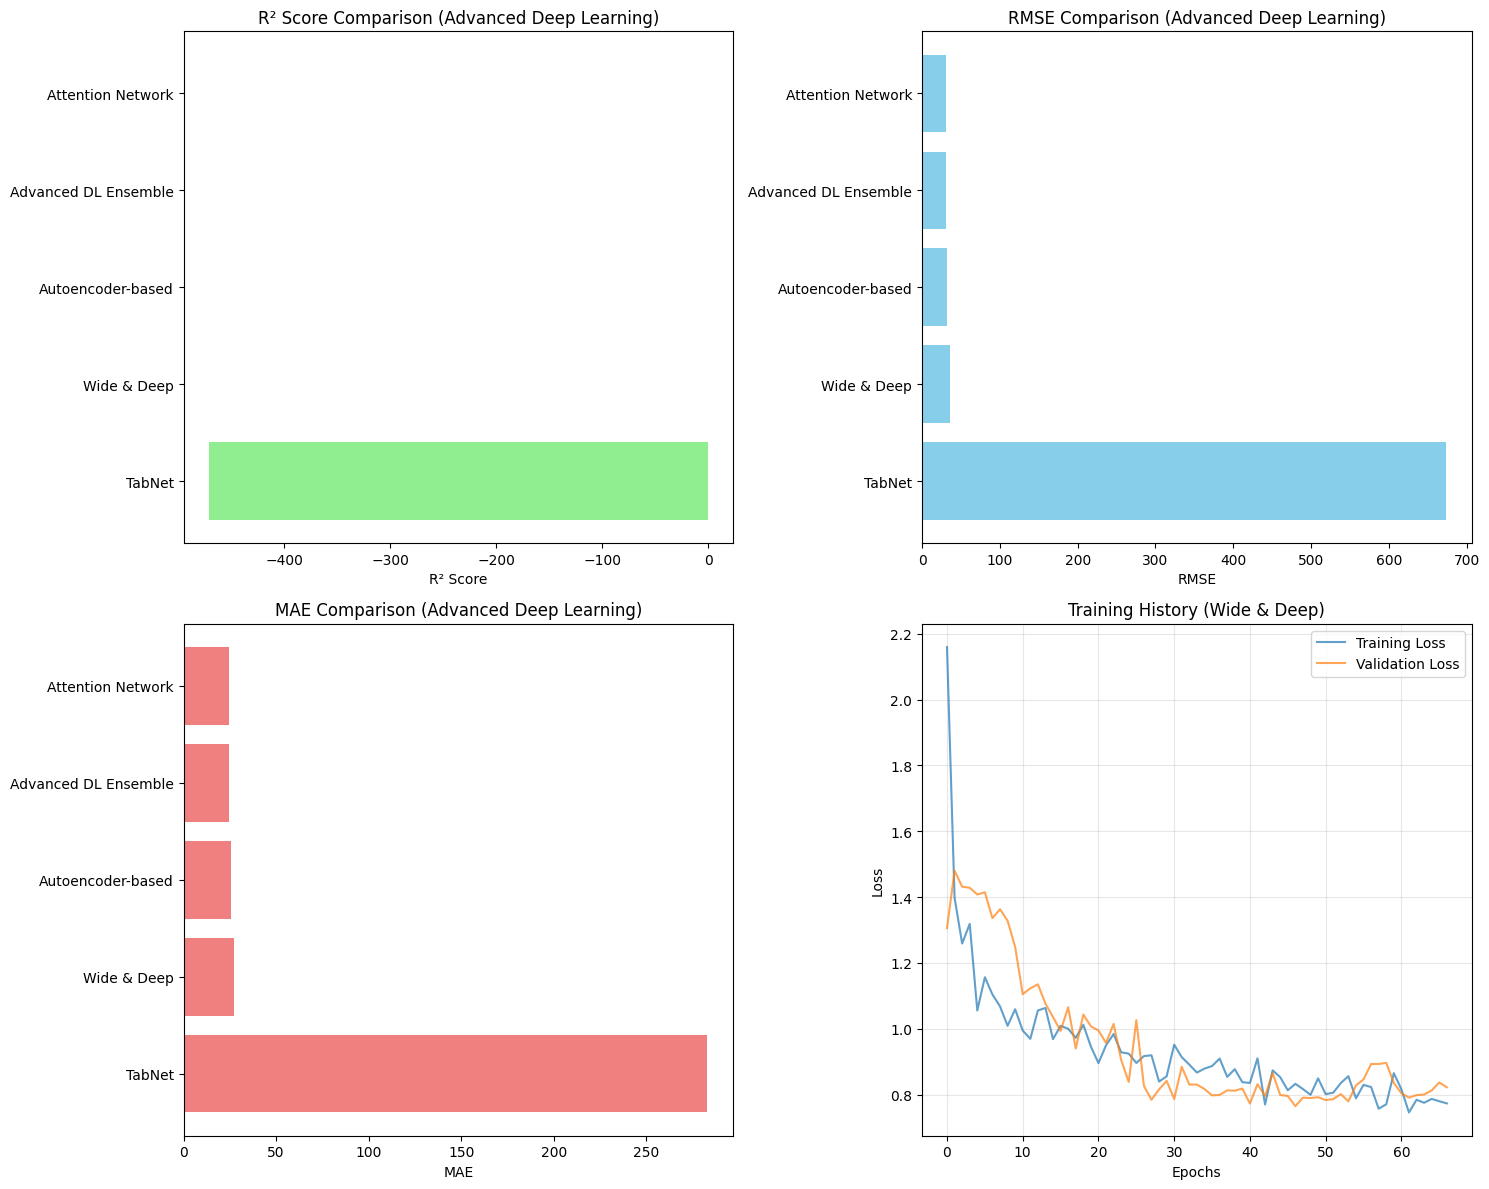


Advanced Deep Learning results saved to: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\advanced_dl_comparison_20251113_145005.csv


In [13]:
# Visualize advanced deep learning model performance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# R² comparison
axes[0, 0].barh(advanced_dl_df['model_name'], advanced_dl_df['r2'], color='lightgreen')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('R² Score Comparison (Advanced Deep Learning)')
axes[0, 0].invert_yaxis()

# RMSE comparison
axes[0, 1].barh(advanced_dl_df['model_name'], advanced_dl_df['rmse'], color='skyblue')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('RMSE Comparison (Advanced Deep Learning)')
axes[0, 1].invert_yaxis()

# MAE comparison
axes[1, 0].barh(advanced_dl_df['model_name'], advanced_dl_df['mae'], color='lightcoral')
axes[1, 0].set_xlabel('MAE')
axes[1, 0].set_title('MAE Comparison (Advanced Deep Learning)')
axes[1, 0].invert_yaxis()

# Training history for best model (example with Wide & Deep)
axes[1, 1].plot(history_wd.history['loss'], label='Training Loss', alpha=0.7)
axes[1, 1].plot(history_wd.history['val_loss'], label='Validation Loss', alpha=0.7)
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_title('Training History (Wide & Deep)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save advanced deep learning results
advanced_dl_results_path = os.path.join(MODEL_BASE_PATH, f"advanced_dl_comparison_{timestamp}.csv")
advanced_dl_df.to_csv(advanced_dl_results_path, index=False)
print(f"\nAdvanced Deep Learning results saved to: {advanced_dl_results_path}")

## 9. Create Advanced Deep Learning Model Registry

In [14]:
# Create comprehensive model registry for advanced deep learning models
advanced_dl_registry = {
    'best_advanced_dl_model': {
        'name': advanced_dl_df.iloc[0]['model_name'],
        'metrics': advanced_dl_df.iloc[0].to_dict(),
        'timestamp': timestamp
    },
    'all_advanced_dl_models': advanced_dl_df.to_dict('records'),
    'model_architectures': {
        'wide_deep': {
            'description': 'Wide & Deep architecture combining linear and deep components',
            'path': wd_path,
            'input_format': 'multiple_inputs',
            'requires_embeddings': True
        },
        'attention': {
            'description': 'Multi-head attention mechanism for tabular data',
            'path': att_path,
            'input_format': 'multiple_inputs',
            'requires_embeddings': True
        },
        'autoencoder_based': {
            'description': 'Feature learning with autoencoder + regressor',
            'autoencoder_path': ae_path,
            'encoder_path': encoder_path,
            'regressor_path': encoded_reg_path,
            'input_format': 'single_input',
            'requires_preprocessing': 'encoder'
        },
        'advanced_ensemble': {
            'description': 'Ensemble of MLP, ResNet, and Highway networks',
            'path': ensemble_path,
            'input_format': 'single_input',
            'architecture_components': ['mlp', 'residual', 'highway']
        }
    },
    'preprocessing_artifacts': {
        'numerical_scaler': 'StandardScaler fitted on training data',
        'target_scaler': 'StandardScaler for target variable',
        'label_encoders': 'Dictionary of LabelEncoders for categorical variables',
        'embedding_dimensions': embedding_dims
    },
    'feature_info': {
        'feature_columns': feature_cols,
        'categorical_features': categorical_features,
        'numerical_features': numerical_features,
        'total_features': len(feature_cols)
    },
    'training_info': {
        'dataset_size': len(df),
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'training_timestamp': timestamp,
        'tensorflow_version': tf.__version__
    }
}

# Add TabNet info if available
if tabnet_available and tabnet_r2 is not None:
    advanced_dl_registry['model_architectures']['tabnet'] = {
        'description': 'Google TabNet for tabular deep learning',
        'path': tabnet_path,
        'input_format': 'numpy_array',
        'framework': 'pytorch',
        'feature_importance_available': True
    }

# Save advanced deep learning registry
advanced_registry_path = os.path.join(MODEL_BASE_PATH, "advanced_dl_model_registry.json")
with open(advanced_registry_path, 'w') as f:
    json.dump(advanced_dl_registry, f, indent=2, default=str)

print(f"Advanced Deep Learning model registry created: {advanced_registry_path}")

# Save preprocessing artifacts
preprocessing_artifacts = {
    'numerical_scaler': scaler,
    'target_scaler': target_scaler,
    'label_encoders': label_encoders,
    'embedding_dims': embedding_dims,
    'feature_columns': feature_cols,
    'categorical_features': categorical_features,
    'numerical_features': numerical_features
}

artifacts_path = os.path.join(MODEL_BASE_PATH, "model_artifacts", f"advanced_dl_preprocessing_{timestamp}.pkl")
joblib.dump(preprocessing_artifacts, artifacts_path)
print(f"Preprocessing artifacts saved: {artifacts_path}")

print("\n" + "=" * 80)
print("ADVANCED DEEP LEARNING MODEL TRAINING COMPLETED!")
print("=" * 80)
print(f"Total advanced DL models trained: {len(advanced_dl_results)}")
print(f"Best performing model: {advanced_dl_df.iloc[0]['model_name']}")
print(f"Best R² score: {advanced_dl_df.iloc[0]['r2']:.4f}")
print(f"\nAll models saved in: {os.path.join(MODEL_BASE_PATH, 'deep_learning')}")
print(f"Registry file: {advanced_registry_path}")
print(f"Preprocessing artifacts: {artifacts_path}")
print("\nAdvanced deep learning models are ready for production deployment!")

Advanced Deep Learning model registry created: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\advanced_dl_model_registry.json
Preprocessing artifacts saved: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\model_artifacts\advanced_dl_preprocessing_20251113_145005.pkl

ADVANCED DEEP LEARNING MODEL TRAINING COMPLETED!
Total advanced DL models trained: 5
Best performing model: Attention Network
Best R² score: 0.0255

All models saved in: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\deep_learning
Registry file: c:\Users\proda\OneDrive\Documents\Gus Agung\PROJECT ISENG\PROJECT AFTER LULUS\GYE-Project\GYE-OTA-ANALYSIS\Airbnb-ML-Dashboard\ml_models\advanced_dl_model_registry.json
Preprocessing artifacts: c:\Users\proda\OneDrive